In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
from tqdm import tqdm
import time
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle
from pathlib import Path
from glob import glob

from scipy.stats import normaltest
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import FastICA

sys.path.append("../") 
from sparsenet.ImageDataset import NatPatchDataset
from sparsenet.atlSparseNet import SparseNet, argsSparseNet, initWeights
from sparsenet.plotting import plot_rf
from sparsenet import snExperiments as snExperiments

In [11]:
opts={'learning_rate':1e-3,'n_neuron':400,'epoch':50}
arg = argsSparseNet(opts) # Defaults encoded in class
# if use cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# create net
sparse_netInit = SparseNet(arg.n_neuron, arg.size, R_lr=arg.r_learning_rate, lmda=arg.reg, device=device)
sparse_netRand = SparseNet(arg.n_neuron, arg.size, R_lr=arg.r_learning_rate, lmda=arg.reg, device=device)
# load data
batch_size = 500
dataloader = DataLoader(NatPatchDataset(arg.batch_size, arg.size, arg.size, fpath='./data/IMAGES.mat'), batch_size=batch_size, shuffle=True)

In [12]:
# Measure eigenvectors of images
allImages = []
for img_batch in dataloader:
    allImages.append(torch.flatten(img_batch,1))
allImages = torch.cat(allImages)
imCov = torch.cov(allImages.T)
imEval,imEvec = torch.linalg.eigh(imCov)
imEval,idxEval = torch.sort(imEval, descending=True)
imEval[imEval<0]=torch.tensor(np.finfo('float32').eps)
imEvec = imEvec[:,idxEval]
NEV = len(imEval)

In [19]:
# Initialize Receptive Fields using Beta Optimization
# Goal: maximize variance of beta on each eigenvalue while minimizing difference between average beta on eigenvector and it's true eigenvalue
# We can do this by picking a distribution for which we know the mean (let's use exponential for reasons I'll explain later)
# Then, sample from that distribution across the betas for each eigenvector, where we parameterize the distribution to have a mean equal to the eigenvalue
# Do this for every eigenvector
# Next, randomly assign a sign 
# Generate receptive fields...

# Do above procedure with this function---
iweight = initWeights(imEvec, imEval, arg.n_neuron, np.sqrt)
sparse_netInit.U.weight.data = iweight.to(device)
sparse_netInit.normalize_weights()

iweight = initWeights(imEvec, imEval, arg.n_neuron)
sparse_netRand.U.weight.data = iweight.to(device)
sparse_netRand.normalize_weights()

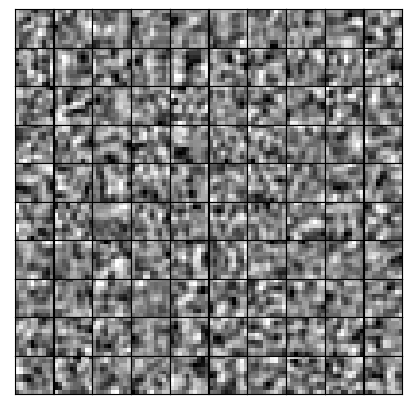

In [14]:
rfs = sparse_netInit.U.weight.T.reshape(arg.n_neuron, arg.size, arg.size).cpu().data.numpy()
fig = plot_rf(rfs, arg.n_neuron, arg.size, showRFs=10**2)

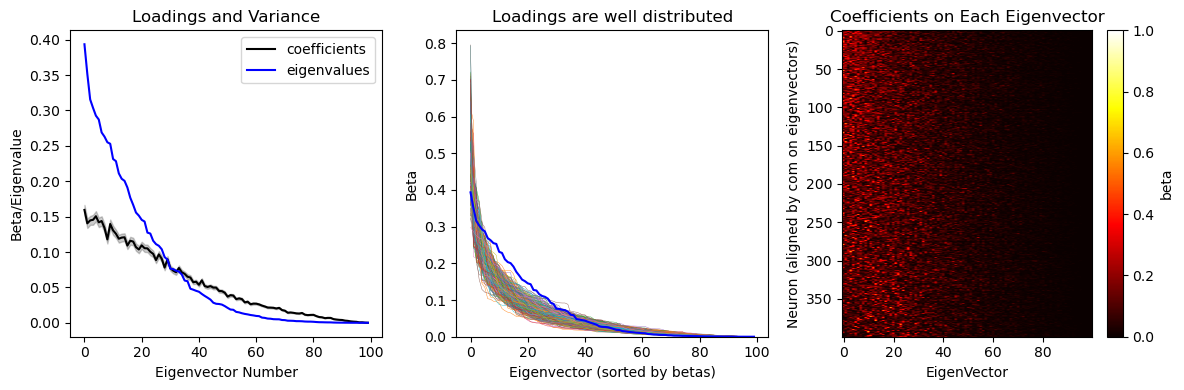

In [15]:
# Measure dot product of RFs on eigenvectors
rfs = sparse_netInit.U.weight.clone().cpu().detach()
rfs = rfs / torch.norm(rfs,dim=0) # make sure they are normed!
beta = torch.abs(imEvec.T @ rfs)

# Measure dot product of RFs on images
rfActivation = allImages @ rfs

# Make summary plots of betas
fig,ax = plt.subplots(1,3,figsize=(12,4))

# Plot betas
mnBeta = torch.mean(beta, dim=1)
seBeta = torch.std(beta, dim=1)/np.sqrt(beta.shape[1])
# plt.plot(range(NEV), beta, c='lightgrey', linewidth=0.2, alpha=0.1)
ax[0].plot(range(NEV), torch.mean(beta, dim=1), c='k', linewidth=1.5, label='coefficients')
ax[0].fill_between(range(NEV), mnBeta+seBeta, mnBeta-seBeta, color='k', alpha=0.2)
ax[0].plot(range(NEV), imEval, c='b', label='eigenvalues')
ax[0].legend()
ax[0].set_xlabel('Eigenvector Number')
ax[0].set_ylabel('Beta/Eigenvalue')
ax[0].set_title('Loadings and Variance')

# Plot sorted betas
sortBeta = torch.sort(beta,dim=0,descending=True)[0]
mnSortBeta = torch.mean(sortBeta,dim=1)
seSortBeta = torch.std(sortBeta,dim=1)/np.sqrt(beta.shape[1])
ax[1].plot(range(NEV), sortBeta, linewidth=0.3)
# ax[1].plot(range(NEV), mnSortBeta, c='k', linewidth=0.5)
# ax[1].fill_between(range(NEV), mnSortBeta+seSortBeta, mnSortBeta-seSortBeta, color='k', alpha=0.2)
ax[1].plot(range(NEV), imEval, c='b', label='evals')
ax[1].set_ylim(0)
ax[1].set_xlabel('Eigenvector (sorted by betas)')
ax[1].set_ylabel('Beta')
ax[1].set_title('Loadings are well distributed')

# Plot heatmap of all coefficients (sorted by COM)
use2sort = 'eval'
comVals = imEval if use2sort=='eval' else np.arange(NEV)
comBeta = (comVals @ beta.numpy()) / torch.sum(beta * beta, dim=0)
idxComBeta = torch.argsort(comBeta,descending=True)
hm=ax[2].imshow(beta[:,idxComBeta].T,aspect='auto', cmap='hot', vmin=0, vmax=1)
ax[2].set_xlabel('EigenVector')
ax[2].set_ylabel('Neuron (aligned by com on eigenvectors)')
ax[2].set_title('Coefficients on Each Eigenvector')
plt.colorbar(hm, ax=ax[2], label='beta')

# Make it pretty
plt.tight_layout()


# Compare entropy of betas to similarity
normBeta = beta/torch.sum(beta,dim=0)
entropy = -torch.nansum(normBeta * torch.log2(beta),dim=0)
# plt.hist(entropy.numpy())

In [20]:
# then train
optimInit = torch.optim.SGD([{'params': sparse_netInit.U.weight, "lr": arg.learning_rate}])
optimRand = torch.optim.SGD([{'params': sparse_netRand.U.weight, "lr": arg.learning_rate}])

# track loss & measure integration
trackLossInit = torch.zeros(arg.epoch*len(dataloader))
alignMeanInit = torch.zeros((arg.n_neuron,arg.epoch*len(dataloader)))
trackLossRand = torch.zeros(arg.epoch*len(dataloader))
alignMeanRand = torch.zeros((arg.n_neuron,arg.epoch*len(dataloader)))
batchIdx = 0
for e in tqdm(range(arg.epoch)):
    running_loss = 0
    c = 0
    for img_batch in dataloader: #tqdm(dataloader, desc='training', total=len(dataloader)):
        img_batch = torch.flatten(img_batch,1).to(device)
        
        # update
        pred = sparse_netInit(img_batch)
        loss = ((img_batch - pred) ** 2).sum()
        running_loss += loss.item()
        loss.backward()
        # update U
        optimInit.step()
        # zero grad
        sparse_netInit.zero_grad()
        # norm
        sparse_netInit.normalize_weights()
        # save values
        trackLossInit[batchIdx]=loss.item()
        alignMeanInit[:,batchIdx]=sparse_netInit.measureAlignment(img_batch)
        
        # update
        pred = sparse_netRand(img_batch)
        loss = ((img_batch - pred) ** 2).sum()
        running_loss += loss.item()
        loss.backward()
        # update U
        optimRand.step()
        # zero grad
        sparse_netRand.zero_grad()
        # norm
        sparse_netRand.normalize_weights()
        # save values
        trackLossRand[batchIdx]=loss.item()
        alignMeanRand[:,batchIdx]=sparse_netRand.measureAlignment(img_batch)
        
        c += 1
        batchIdx += 1

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:21<00:00,  1.63s/it]


Text(0, 0.5, 'Similarity')

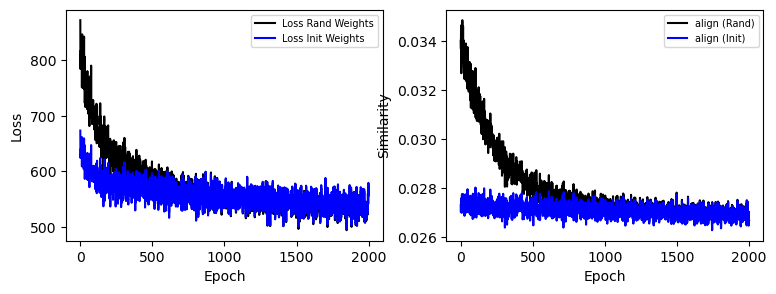

In [21]:
fig,ax = plt.subplots(1,2,figsize=(9,3))

ax[0].plot(range(arg.epoch*len(dataloader)), trackLossRand, c='k', label='Loss Rand Weights')
ax[0].plot(range(arg.epoch*len(dataloader)), trackLossInit, c='b', label='Loss Init Weights')
# ax[0].set_xlim(0,100)

# Plot Similarity
ax[1].plot(range(arg.epoch*len(dataloader)), torch.mean(alignMeanRand,axis=0), c='k', label='align (Rand)')
ax[1].plot(range(arg.epoch*len(dataloader)), torch.mean(alignMeanInit,axis=0), c='b', label='align (Init)')
# ax[1].set_xlim(0,100)

for i in range(2):
    ax[i].set_xlabel('Epoch')
    ax[i].legend(fontsize=7)
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Similarity')

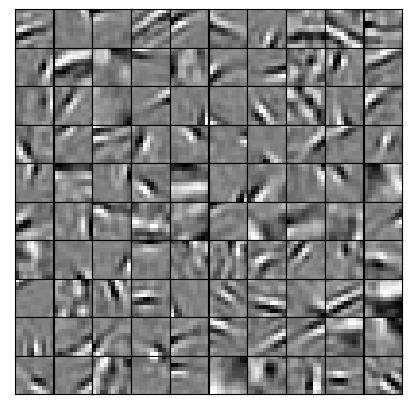

In [38]:
rfs = sparse_net.U.weight.T.reshape(arg.n_neuron, arg.size, arg.size).cpu().data.numpy()
fig = plot_rf(rfs, arg.n_neuron, arg.size, showRFs=10**2)